<a href="https://colab.research.google.com/github/Rafi076/RTFER/blob/main/RTFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Clone framework repository

In [1]:
!git clone https://github.com/Rafi076/RTFER_Framework.git


Cloning into 'RTFER_Framework'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 9), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 187.37 KiB | 4.68 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# Step 2: Unzip dataset

In [2]:
import zipfile
zip_path = "/content/FER-2013.zip"
extract_to = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("Unzipped successfully.")


Unzipped successfully.


# Step 3: Import libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix

# Step 4: Define transforms for training and testing


In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(48, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Step 5: Load dataset and create subsets


In [5]:
train_dir = "/content/FER-2013/train"
test_dir = "/content/FER-2013/test"
train_data_full = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

subset_size = 8000
train_subset_indices = list(range(subset_size))
train_data = Subset(train_data_full, train_subset_indices)

val_percent = 0.1
num_val = int(len(train_data) * val_percent)
indices = np.random.permutation(len(train_data))
val_indices = indices[:num_val]
train_indices = indices[num_val:]

train_subset = Subset(train_data, train_indices)
val_subset = Subset(train_data, val_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
class_names = train_data_full.classes
print("Classes:", class_names)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Step 6: Optional preview of sample images


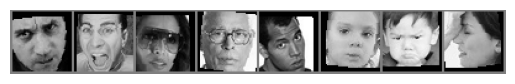

angry angry angry fear angry angry angry fear


In [6]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{class_names[labels[j]]}' for j in range(8)))

# Step 7: Define ResNet model for 7 emotion classes
class ResNetFER(nn.Module):
    def __init__(self):
        super(ResNetFER, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 7)

    def forward(self, x):
        return self.model(x)

# Step 8: Initialize model, freeze layers, and configure training


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetFER().to(device)
torch.backends.cudnn.benchmark = True

for param in model.model.parameters():
    param.requires_grad = False
for param in model.model.layer3.parameters():
    param.requires_grad = True
for param in model.model.layer4.parameters():
    param.requires_grad = True
for param in model.model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_val_acc = 0.0
patience = 5
patience_counter = 0
best_model_state = None

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.1MB/s]


# Step 9: Train model with validation and early stopping


In [10]:
from tqdm import tqdm

epochs = 25
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # === VALIDATION ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === EARLY STOPPING ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Restore the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Best model restored with val accuracy: {best_val_acc:.2f}%")


Epoch 1/25: 100%|██████████| 57/57 [01:58<00:00,  2.08s/it]


Epoch 1, Train Loss: 47.4389, Train Acc: 79.57%, Val Loss: 7.2729, Val Acc: 67.38%


Epoch 2/25: 100%|██████████| 57/57 [01:59<00:00,  2.10s/it]


Epoch 2, Train Loss: 47.7362, Train Acc: 79.19%, Val Loss: 7.1993, Val Acc: 67.50%


Epoch 3/25: 100%|██████████| 57/57 [01:58<00:00,  2.07s/it]


Epoch 3, Train Loss: 46.7634, Train Acc: 80.28%, Val Loss: 7.3708, Val Acc: 66.88%


Epoch 4/25: 100%|██████████| 57/57 [01:59<00:00,  2.09s/it]


Epoch 4, Train Loss: 47.1899, Train Acc: 79.57%, Val Loss: 7.3644, Val Acc: 64.88%


Epoch 5/25: 100%|██████████| 57/57 [01:59<00:00,  2.10s/it]


Epoch 5, Train Loss: 47.0883, Train Acc: 79.94%, Val Loss: 7.3294, Val Acc: 65.62%


Epoch 6/25: 100%|██████████| 57/57 [01:58<00:00,  2.09s/it]


Epoch 6, Train Loss: 46.6954, Train Acc: 80.26%, Val Loss: 7.1199, Val Acc: 69.00%


Epoch 7/25: 100%|██████████| 57/57 [01:56<00:00,  2.04s/it]


Epoch 7, Train Loss: 46.8266, Train Acc: 80.53%, Val Loss: 7.3009, Val Acc: 66.50%


Epoch 8/25: 100%|██████████| 57/57 [01:57<00:00,  2.06s/it]


Epoch 8, Train Loss: 46.1557, Train Acc: 80.78%, Val Loss: 7.2541, Val Acc: 67.75%


Epoch 9/25: 100%|██████████| 57/57 [01:58<00:00,  2.08s/it]


Epoch 9, Train Loss: 46.0248, Train Acc: 80.96%, Val Loss: 7.3605, Val Acc: 66.75%


Epoch 10/25: 100%|██████████| 57/57 [01:59<00:00,  2.10s/it]


Epoch 10, Train Loss: 46.2389, Train Acc: 80.85%, Val Loss: 7.2161, Val Acc: 67.12%


Epoch 11/25: 100%|██████████| 57/57 [01:58<00:00,  2.07s/it]


Epoch 11, Train Loss: 46.6763, Train Acc: 80.32%, Val Loss: 7.4138, Val Acc: 65.88%
Early stopping triggered at epoch 11
Best model restored with val accuracy: 69.00%


# Step 10: Load and save the best model

In [ ]:
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Best model restored with val accuracy: {best_val_acc:.2f}%")
    torch.save(model.state_dict(), "resnet18_fer2013_best.pth")
    print("Best model saved as 'resnet18_fer2013_best.pth'")


# Step 11: Download saved model file


In [ ]:
from google.colab import files
files.download("resnet18_fer2013_best.pth")